## Intensity comparison - bic/non-bic - epitope blocking experiments
- <a href='#modules'>Import modules</a>
- <a href='#specifydirectory'>Specify experiment directory</a>
- <a href='#makedict'>Make empty dictionary to store results</a>
- <a href='#makepdfs'>Make PDFs of raw images</a>
- <a href='#loadingprocessinganalysing'>Loading, processing and batch analyzing the images</a>
    - <a href='#preprocessing'>Preprocessing</a>
    - <a href='#segmenting'>Segmenting</a>
- <a href='#quantitativeimageanalysis'>Quantitative image analysis</a>
- <a href='#plots'>Plots</a>
    - <a href='#checknormality'>Check normality</a>
    - <a href='#barplots'>Barplots</a>
    - <a href='#boxwhisker'>Box and whisker plots</a>
    - <a href='#violinplots'>Violin plots</a>
- <a href='#makingsense'>Making sense</a>

<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [5]:
expdir='/Volumes/ukps-all$/AG-Rizzoli/Philipp/' #master folder
protein="_int" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate
- The dictionary 'results' will store the mean of each result for each image (e.g. mean intensity of the image)
- The dictionary 'histogram_results' will store the histograms of the intensities for each image
- The dictionary 'region_props' will store the region properties of the 'spots' (individual, discrete objects) that are detected in the images in the segmentation stage. These are morphological/geographical parameters like location, area, perimeter, etc.

In [10]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "Nuclei raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual mask only":[],
           "ECM mean intensity: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "Nuclei mean intensity: soma only":[],
           "Nuclei mean intensity: neurites only":[],
           "Nuclei mean intensity: matlab manual mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of nuclei spots in soma mask":[],
           "Number of nuclei spots in neurites mask":[],
           "Number of nuclei spots in matlab manual mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of nuclei spots in soma mask after bg subtraction":[],
           "Number of nuclei spots in neurites mask after bg subtraction":[],
           "Number of nuclei spots in matlab manual mask after bg subtraction":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "int" in str(filelist[i]):
            if ("TTX" in str(filelist[i]))==False:
                if filelist[i].endswith(".nd2"): 
                    results["filename"].append(filelist[i])
                    histogram_results["filename"].append(filelist[i])
                    regionprops_results["filename"].append(filelist[i])
                    results["exp condition"].append(filelist[i].split('/')[-2])
                    histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                    regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                    channeldir="/".join(filelist[i].split("/")[:-2])
                    exec(open(channeldir+"/channels.txt").read())
                    results["ecmchannelno"].append(ecmchannelno)
                    results["nucleichannelno"].append(nucleichannelno)
                    results["synapsechannelno"].append(synapsechannelno)

                    positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                    if positivecontrolcheck.exists():
                        results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

**Let's take a look at which experimental conditions we have**

In [11]:
print("\n".join(list(sorted(set(results["exp condition"])))))

12hrs_Bic
12hrs_DMSO
2hrs_Bic
2hrs_DMSO
4hrs_Bic
4hrs_DMSO
Ctrl_NoBlocking


<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images

**Let's start by loading a random image and looking at the ECM channel:**

Image name: 20191106_int_01_004.nd2
Experimental condition: Ctrl_NoBlocking


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

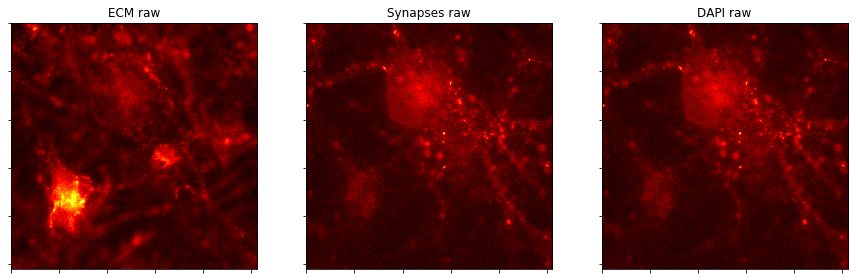

In [12]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


### Masking
Make a mask for the image from the synapse channel - 
- Threshold with Li method (minimizing cross entropy)
- Make a separate mask for soma and neurites:
    - Find the soma by labelling the binary mask --> largest connected component = soma
    - Blur soma --> save this as soma mask
    - Blue remaining area --> save this as neurite mask

Text(0.5, 1.0, 'ECM raw image')

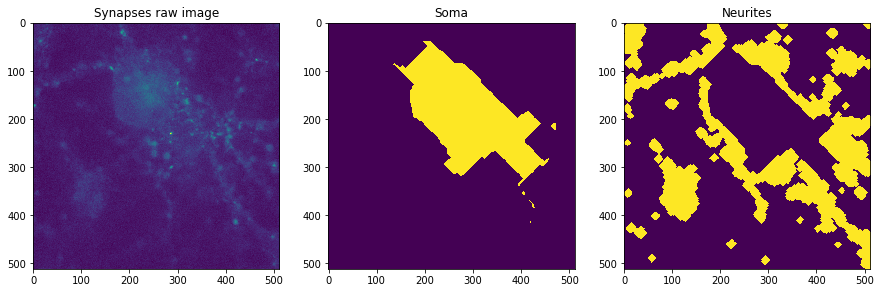

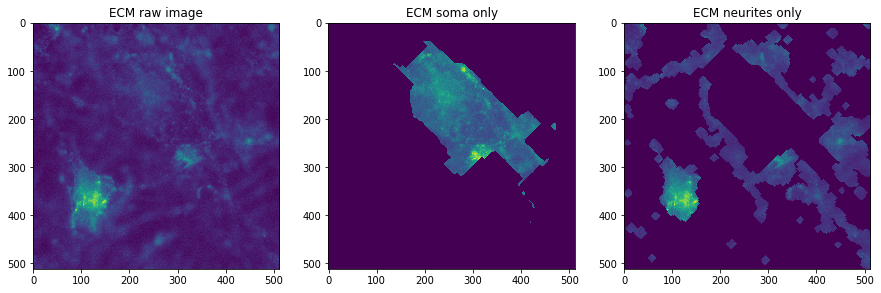

In [13]:
def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

<a id='segmenting'></a> 
#### Make segmentation masks for all images
After optimizing the parameters for preprocessing of the images, we can run the cleaning on all of the images in the experiment.

For each image we will save the **segmentation (spots) mask** which determines where the real signal is in the original image.

In [14]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    ecm_channel_no=results["ecmchannelno"][im]
    nuclei_channel_no=results["nucleichannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        
    soma_mask,neurite_mask=makemask(synapse_image)
    
    results["Soma mask from synapse channel"].append(soma_mask)
    results["Neurites mask from synapse channel"].append(neurite_mask)
    clear_output()        

os.system('say "Segmentation complete"')
print("Done!")

Done!


**Backup the segmentation results before continuing**

We will copy the results dictionary that we've filled so far with the segmentation results, just in case...
Note - this copy stays alive along as this notebook stays alive, i.e. it isn't saved on the hard disk

In [15]:
resultsbackup=deepcopy(results)

#### Optional: load manual segmentation masks from matlab GUI

In [16]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


In [17]:
resultsbackup=deepcopy(results)

### Visualize masking (automatic and manual, if exists) and background reduction for a few random images

Image name: 20190821_int_07_008.nd2
Experimental condition: 4hrs_DMSO


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountere

ECM image - raw mean intensity =  1487.6621551513672
ECM under soma - mean intensity =  2324.03998471574
ECM under soma - mean intensity after bg subtraction =  305.82413852669475
ECM under neurites - mean intensity =  1636.109885602297
ECM under neurites - mean intensity after bg subtraction =  215.54565872140142
ECM under manual mask - mean intensity =  nan
ECM under manual rois mask - mean intensity after bg subtraction =  nan


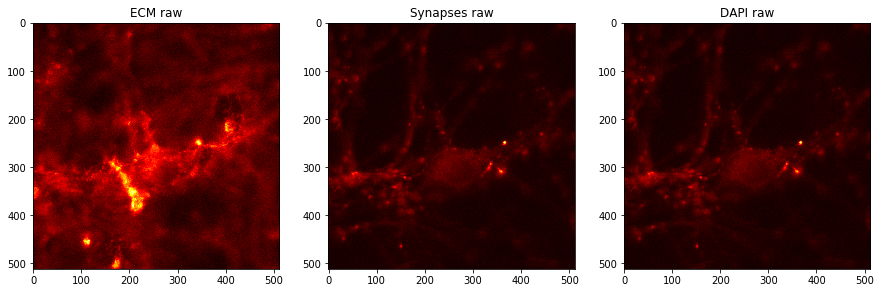

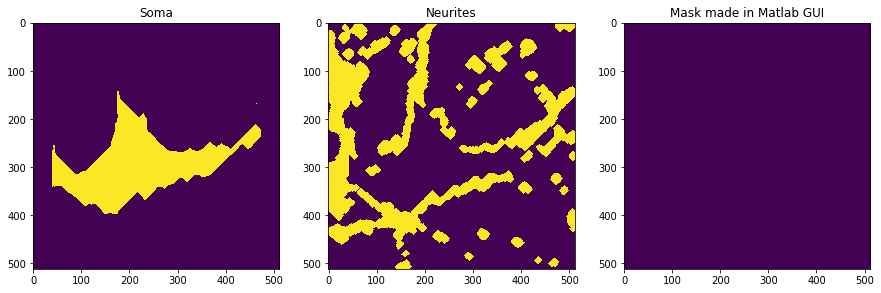

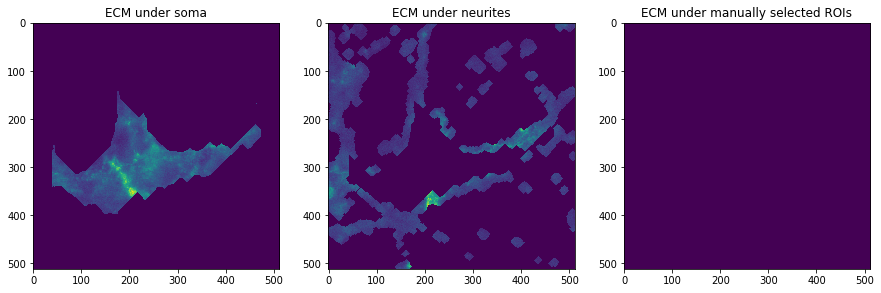

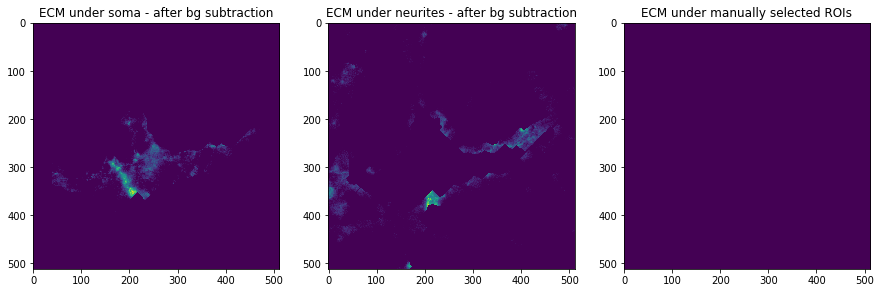

In [18]:
flag=False
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
soma_mask=results["Soma mask from synapse channel"][randomno]
neurites_mask=results["Neurites mask from synapse channel"][randomno]
matlab_mask=results["Manual mask from matlab GUI"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    
            
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurites_mask]=0
ecm_matlabmasked=deepcopy(ecm_image)
synapses_matlabmasked=deepcopy(synapse_image)
if type(matlab_mask)==np.ndarray:
    ecm_matlabmasked[~matlab_mask]=0
    synapses_matlabmasked[~matlab_mask]=0
    flag=True

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')

#show masks
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(132)
plt.imshow(neurites_mask)
plt.title('Neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(matlab_mask)
    plt.title('Mask made in Matlab GUI')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Matlab GUI - no mask was made') 
#show masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked)
plt.title('ECM under soma')
fig.add_subplot(132)
plt.imshow(ecm_neuritemasked)
plt.title('ECM under neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked)
    plt.title('No manual mask was made') 
#background subtraction    
bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
ecm_somamasked_bgreduced=deepcopy(ecm_image)
ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
ecm_somamasked_bgreduced[~soma_mask]=0
bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
ecm_neuritesmasked_bgreduced[~neurites_mask]=0
ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
if flag==True:
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0

#show bg subtracted masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked_bgreduced)
plt.title('ECM under soma - after bg subtraction')
fig.add_subplot(132)
plt.imshow(ecm_neuritesmasked_bgreduced)
plt.title('ECM under neurites - after bg subtraction')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('No manual mask was made')
#calculate intensities before/after bg subtraction
print('ECM image - raw mean intensity = ',np.nanmean(ecm_image))
print('ECM under soma - mean intensity = ',np.nanmean(ecm_image[soma_mask]))
print('ECM under soma - mean intensity after bg subtraction = ', np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
print('ECM under neurites - mean intensity = ',np.nanmean(ecm_image[neurites_mask]))
print('ECM under neurites - mean intensity after bg subtraction = ', np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
if flag==True:
    print('ECM under manual mask - mean intensity = ',np.nanmean(ecm_image[matlab_mask]))
    print('ECM under manual rois mask - mean intensity after bg subtraction = ', np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))

<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

In [19]:
blockingpaths=np.unique(results["noblock_controldir"])
blockingpaths

array(['/Volumes/ukps-all$/AG-Rizzoli/Philipp/20190821_int_analyse/Ctrl_NoBlocking',
       '/Volumes/ukps-all$/AG-Rizzoli/Philipp/20190903_int_analyse/Ctrl_NoBlocking',
       '/Volumes/ukps-all$/AG-Rizzoli/Philipp/20191028_int_analyse/Ctrl_NoBlocking',
       '/Volumes/ukps-all$/AG-Rizzoli/Philipp/20191106_int_analyse/Ctrl_NoBlocking'],
      dtype='<U74')

In [20]:
ctrlecms={"filename":[]}
blockingpaths=np.unique(results["noblock_controldir"])

for p in range(0,len(blockingpaths)):
    pathecm=str(blockingpaths[p])
    filelistecm = []
    for root, _, filenames in os.walk(pathecm):
         for filename in filenames:
             filelistecm.append(os.path.join(root, filename)) #make a list of all images in control folder
    for l in range(0,len(filelistecm)):
        if filelistecm[l].endswith(".nd2"): 
            ctrlecms["filename"].append(filelistecm[l])

ecmcolour_ctrls=np.zeros((len(ctrlecms["filename"]),1)) #make empty vector to store mean intensity of each image
ecmcolour_somamasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))
ecmcolour_neuritesmasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))

for im in range(0,len(ctrlecms["filename"])):
    with ND2Reader(ctrlecms["filename"][im]) as images:
        ecm_image_ctrl=images[ecm_channel_no-1]
    #convert to array
    ecm_image_ctrl=ecm_image_ctrl.astype(np.int16)
    #normalize intensity to value between 0 and 1
    ecm_image_ctrl=np.divide(ecm_image_ctrl,16383.)
    #append raw mean intensity to vector
    ecmcolour_ctrls[im]=np.nanmean(ecm_image_ctrl)
    ##### calculate the intensity for the masked images separately #########
    soma_mask=results["Soma mask from synapse channel"][im]
    neurites_mask=results["Neurites mask from synapse channel"][im]
    ecmcolour_somamasked_ctrls[im]=np.nanmean(ecm_image_ctrl[soma_mask])
    ecmcolour_neuritesmasked_ctrls[im]=np.nanmean(ecm_image_ctrl[neurites_mask])

#average the vectors
ecm_ctrl_mean=np.nanmean(ecmcolour_ctrls)
ecm_somamasked_ctrl_mean=np.nanmean(ecmcolour_somamasked_ctrls)
ecm_neuritesmasked_ctrl_mean=np.nanmean(ecmcolour_neuritesmasked_ctrls)
print("Mean intensity of non-blocked controls - whole image:",str(ecm_ctrl_mean))
print("Mean intensity of non-blocked controls - under soma mask",str(ecm_somamasked_ctrl_mean))
print("Mean intensity of non-blocked controls - under neurites mask",str(ecm_neuritesmasked_ctrl_mean))

Mean intensity of non-blocked controls - whole image: 0.12734222230490388
Mean intensity of non-blocked controls - under soma mask 0.15523638904134907
Mean intensity of non-blocked controls - under neurites mask 0.12889187046572018


### **Now we can run the analysis in a loop over all the images**

This will take a while...

In [21]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    nuclei_channel_no=results["nucleichannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    nuclei_image=nuclei_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    nuclei_image_raw=deepcopy(nuclei_image)
    synapse_image_raw=deepcopy(synapse_image)
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    ecm_image=np.divide(ecm_image,16383.)
    nuclei_image=np.divide(nuclei_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #read masks
    soma_mask=results["Soma mask from synapse channel"][i]
    neurites_mask=results["Neurites mask from synapse channel"][i]
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
    ecm_somamasked_bgreduced=deepcopy(ecm_image)
    ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
    ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
    ecm_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
    ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
    ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
    ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
    ecm_neuritesmasked_bgreduced[~neurites_mask]=0
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    #for synapse image
    bg_somamask=np.mean(ndi.median_filter(synapse_image[soma_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[soma_mask],size=5))
    synapse_somamasked_bgreduced=deepcopy(synapse_image)
    synapse_somamasked_bgreduced=np.subtract(synapse_somamasked_bgreduced,bg_somamask)
    synapse_somamasked_bgreduced[synapse_somamasked_bgreduced<0]=0
    synapse_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(synapse_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[neurites_mask],size=5))
    synapse_neuritesmasked_bgreduced=deepcopy(synapse_image)
    synapse_neuritesmasked_bgreduced=np.subtract(synapse_neuritesmasked_bgreduced,bg_neuritesmask)
    synapse_neuritesmasked_bgreduced[synapse_neuritesmasked_bgreduced<0]=0
    synapse_neuritesmasked_bgreduced[~neurites_mask]=0
    synapse_matlabmasked_bgreduced=deepcopy(synapse_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(synapse_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[matlab_mask],size=5))
        synapse_matlabmasked_bgreduced=np.subtract(synapse_matlabmasked_bgreduced,bg_matlabmask)
        synapse_matlabmasked_bgreduced[synapse_matlabmasked_bgreduced<0]=0
        synapse_matlabmasked_bgreduced[~matlab_mask]=0
    #make raw ecm images normalized to the raw intensity of the non-blocked controls 
    ecm_image_normtoctrl=deepcopy(ecm_image)
    ecm_image_normtoctrl=np.divide(ecm_image_normtoctrl,ecm_ctrl_mean)
    #make histograms of the raw images
    ecm_hist,_ = np.histogram(ecm_image,bins=np.linspace(0.,1.,50))
    nuclei_hist,_ = np.histogram(nuclei_image,bins=np.linspace(0.,1.,50))
    synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    ##################################################################################    

#append the final results to the dictionary:
    #results based on calculation on raw images
    results["ECM raw intensity, unmasked"].append(np.nanmean(ecm_image_raw))
    results["Nuclei raw intensity, unmasked"].append(np.nanmean(nuclei_image_raw))
    results["Synapse raw intensity, unmasked"].append(np.nanmean(synapse_image_raw))
    results["ECM intensity: unmasked, divded by unblocked condition"].append(np.nanmean(ecm_image_normtoctrl))
    histogram_results["ECM raw intensity- Flattened histogram"].append(ecm_hist) 
    histogram_results["Nuclei raw intensity- Flattened histogram"].append(nuclei_hist)
    histogram_results["Synapse raw intensity- Flattened histogram"].append(synapse_hist)
    #results under mask
    results["ECM mean intensity: soma only"].append(np.nanmean(ecm_image[soma_mask]))
    results["ECM mean intensity: soma only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[soma_mask]))
    results["ECM mean intensity: neurites only"].append(np.nanmean(ecm_image[neurites_mask]))
    results["ECM mean intensity: neurites only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[neurites_mask]))
    if flag==True:
        results["ECM mean intensity: matlab manual mask only"].append(np.nanmean(ecm_image[matlab_mask]))
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[matlab_mask]))
    else:
        results["ECM mean intensity: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity: soma only"].append(np.nanmean(synapse_image[soma_mask]))
    results["Synapse mean intensity: neurites only"].append(np.nanmean(synapse_image[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nanmean(synapse_image[matlab_mask]))
    else:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nan)
    results["Nuclei mean intensity: soma only"].append(np.nanmean(nuclei_image[soma_mask]))
    results["Nuclei mean intensity: neurites only"].append(np.nanmean(nuclei_image[neurites_mask]))
    if flag==True:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nanmean(nuclei_image[neurites_mask]))
    else:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nan)
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    synapse_soma=deepcopy(synapse_image_thresholded)
    synapse_soma[~soma_mask]=0
    synapse_neurites=deepcopy(synapse_image_thresholded)
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_image_thresholded)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask"].append(np.nan)
    #results after background subtraction
    results["ECM mean intensity after bg subtraction: soma only"].append(np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
    results["ECM mean intensity after bg subtraction: soma only, divided by unblocked"].append(np.divide(np.nanmean(ecm_somamasked_bgreduced[soma_mask]),ecm_ctrl_mean))
    results["ECM mean intensity after bg subtraction: neurites only"].append(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
    results["ECM mean intensity after bg subtraction: neurites only, divided by unblocked"].append(np.divide(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]),ecm_ctrl_mean))
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]),ecm_ctrl_mean))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity after bg subtraction: soma only"].append(np.nanmean(synapse_somamasked_bgreduced[soma_mask]))
    results["Synapse mean intensity after bg subtraction: neurites only"].append(np.nanmean(synapse_neuritesmasked_bgreduced[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(synapse_matlabmasked_bgreduced[matlab_mask]))
    else:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
    synapse_soma=deepcopy(synapse_somamasked_bgreduced)
    synapse_neurites=deepcopy(synapse_neuritesmasked_bgreduced)
    synapse_soma[~soma_mask]=0
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_matlabmasked_bgreduced)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(np.nan)
    #save the region properties of the spots masks, for future analysis
    synapseprops_soma=skimage.measure.regionprops(synapse_labeled_mask_soma)   
    synapseprops_neurites=skimage.measure.regionprops(synapse_labeled_mask_neurites)                                                                             
    regionprops_results["Synapse colour - regionprops soma"].append(synapseprops_soma)
    regionprops_results["Synapse colour - regionprops neurites"].append(synapseprops_neurites)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [22]:
df=pd.DataFrame(results)
df['expname']=filelist[i].split("/")[:-2][-1]#add exp id

<a id='checknormality'></a> 
**How does the intensity distribute?**

Ultimately, we will mostly be comparing the mean fluorescence intensity between different experimental conditions (e.g. different times, different drugs..). It might be useful to see how the mean fluorescence intensity distributes, both in total and in different conditions. So, we can start by looking at histograms of the different variables. Also, we can use the Kolmogorov–Smirnov statistical test to see if our data distributes normally. If it doesn't (which is often the case), we may want to consider using a non-parametric statistical analysis later on.

*Note: I often like to use a Python package called Seaborn (which i shorten to sns in my code) to make pretty plots

<class 'numpy.ndarray'>
The variable distributes normally
<class 'numpy.ndarray'>
The variable does not distribute normally
<class 'numpy.ndarray'>
The variable distributes normally
<class 'numpy.ndarray'>
The variable distributes normally
<class 'numpy.ndarray'>
The variable distributes normally
<class 'numpy.ndarray'>
The variable distributes normally
<class 'numpy.ndarray'>
The variable distributes normally


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won'

<class 'numpy.ndarray'>
The variable does not distribute normally


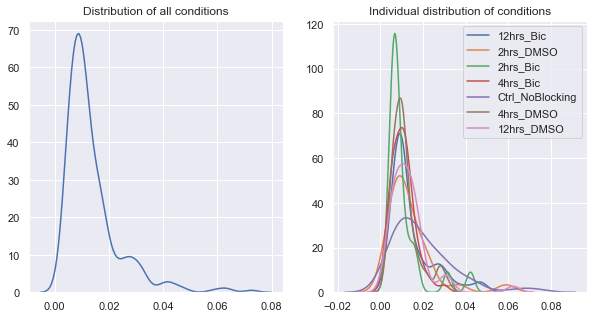

In [23]:
variable="ECM mean intensity after bg subtraction: matlab manual mask only" #change me

x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp condition"])):
    d2p=df[df["exp condition"]==condition]
    sns.kdeplot(df[df["exp condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    
    x=d2p[variable].values
    normdvar=(x-x.mean())/x.std()
    print(type(normdvar))

    [_,pval]=ss.kstest(normdvar,'norm')
    if pval<0.05:
        print("The variable does not distribute normally")
    else:
        print("The variable distributes normally")


    

<a id='makingsense'></a> 
### Making sense

Let's add some human-understandable tags to the DataFrame, so that we can plot what we want more easily.
- A tag for the incubation time
- A tag for the treatment condition (Bic/DMSO)

In [25]:
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'No Blocking'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'No Blocking'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hr_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'
#experimental or control
df2['ExporCtrl']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'ExporCtrl'] = 'Ctrl'

for i in range(0,len(df2)):
    df2['expname'][i]=df2["filename"][i].split("/")[:-2][-1]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


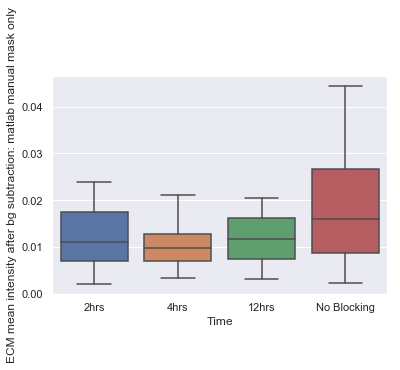

In [26]:
df2show=df2[df2["Drug"]=="DMSO"]
sns.boxplot(data=df2show,x="Time",y=variable,
           order=['2hrs','4hrs','12hrs','No Blocking'],showfliers=False)

In [27]:
var=variable
#
unblocked=df2show[df2show["Time"]=="No Blocking"][var].dropna().values
twohr=df2show[df2show["Time"]=="2hrs"][var].dropna().values
fourhr=df2show[df2show["Time"]=="4hrs"][var].dropna().values
twelvehr=df2show[df2show["Time"]=="12hrs"][var].dropna().values


[stat,pval_2_4]=stats.ttest_ind(twohr, fourhr)
[stat,pval_4_12]=stats.ttest_ind(fourhr, twelvehr)
[stat,pval_12_unblocked]=stats.ttest_ind(twelvehr, unblocked)
[stat,pval_2_12]=stats.ttest_ind(twelvehr, twohr)

print('  2 and 4 '+str(pval_2_4*2))
print('  4 and 12 '+str(pval_4_12*2))
print('  12 and ublk '+str(pval_12_unblocked*2))
print('  12 and 2 '+str(pval_2_12*2))


  2 and 4 0.4862068275313838
  4 and 12 0.47208020912078524
  12 and ublk 0.02850986157389021
  12 and 2 1.754474871121375


## Save dataframe to pickle

In [24]:
df2.to_pickle(expdir+'intturnover_df2.pkl')

In [4]:
df2=pd.read_pickle(expdir+'intturnover_df2.pkl')

KeyError: 0

## Dataframe for exps separately

In [28]:
df2["expname"].unique()

array(['20190821_int_analyse', '20191106_int_analyse',
       '20191028_int_analyse', '20190903_int_analyse'], dtype=object)

In [29]:
var="ECM mean intensity after bg subtraction: matlab manual mask only" #change me

means={"expname":[],"Time":[],"intensity normd 0 to 1":[], "0 to 1 intensity normd to unblocked mean":[],
      "intensity normd to 2hr":[]}

df2read=df2#[(df2["expname"]!="20191028_int")]
           #& (df2["expname"]!="20181113_NCAN_analyse")]


for exp in df2read["expname"].unique():
    dfcalc=df2read[df2read["expname"]==exp]
    
    means["expname"].append(exp)
    means["Time"].append('No Blocking')
    dfcalc2=dfcalc[dfcalc["Time"]=="No Blocking"]
    diomean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(diomean)
    means["0 to 1 intensity normd to unblocked mean"].append(1)
    #means["intensity normd to 2hr"].append(np.nan)
    
    means["expname"].append(exp)
    means["Time"].append('2hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="2hrs"]
    twelvemean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)    
    
    means["intensity normd to 2hr"].append(diomean/twelvemean)
    means["intensity normd to 2hr"].append(1)
    
    means["expname"].append(exp)
    means["Time"].append('4hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="4hrs"]
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
    means["expname"].append(exp)
    means["Time"].append('12hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="12hrs"]
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
    
    
    
    
dfmeans=pd.DataFrame(means)

In [30]:
dfmeans

,expname,Time,intensity normd 0 to 1,0 to 1 intensity normd to unblocked mean,intensity normd to 2hr
0,20190821_int_analyse,No Blocking,0.023794,1.000000,2.477447
1,20190821_int_analyse,2hrs,0.009604,0.403641,1.000000
2,20190821_int_analyse,4hrs,0.011999,0.504300,1.249376
3,20190821_int_analyse,12hrs,0.011832,0.497276,1.231974
4,20191106_int_analyse,No Blocking,0.009958,1.000000,1.207833
5,20191106_int_analyse,2hrs,0.008245,0.827929,1.000000
6,20191106_int_analyse,4hrs,0.007714,0.774657,0.935656
7,20191106_int_analyse,12hrs,0.007285,0.731537,0.883574
8,20191028_int_analyse,No Blocking,0.016433,1.000000,2.157138
9,20191028_int_analyse,2hrs,0.007618,0.463577,1.000000


## stats

### ttests

In [31]:
var="intensity normd to 2hr"
#
unblocked=dfmeans[dfmeans["Time"]=="No Blocking"][var].dropna().values
twohr=dfmeans[dfmeans["Time"]=="2hrs"][var].dropna().values
fourhr=dfmeans[dfmeans["Time"]=="4hrs"][var].dropna().values
twelvehr=dfmeans[dfmeans["Time"]=="12hrs"][var].dropna().values


[stat,pval_2_4]=stats.ttest_ind(twohr, fourhr)
[stat,pval_4_12]=stats.ttest_ind(fourhr, twelvehr)
[stat,pval_12_unblocked]=stats.ttest_ind(twelvehr, unblocked)
[stat,pval_2_12]=stats.ttest_ind(twelvehr, twohr)

print(' normd to 2 - 2 and 4 '+str(pval_2_4*2))
print(' normd to 2 - 4 and 12 '+str(pval_4_12*2))
print(' normd to 2 - 12 and ublk '+str(pval_12_unblocked))
print(' normd to 2 - 12 and 2 '+str(pval_2_12))

var="0 to 1 intensity normd to unblocked mean"
unblocked=dfmeans[dfmeans["Time"]=="No Blocking"][var].dropna().values
twohr=dfmeans[dfmeans["Time"]=="2hrs"][var].dropna().values
fourhr=dfmeans[dfmeans["Time"]=="4hrs"][var].dropna().values
twelvehr=dfmeans[dfmeans["Time"]=="12hrs"][var].dropna().values

[stat,pval_2_4]=stats.ttest_ind(twohr, fourhr)
[stat,pval_4_12]=stats.ttest_ind(fourhr, twelvehr)
[stat,pval_12_unblocked]=stats.ttest_ind(twelvehr, unblocked)
[stat,pval_2_12]=stats.ttest_ind(twelvehr, twohr)
print('')
print(' normd to ub - 2 and 4 '+str(pval_2_4))
print(' normd to ub - 4 and 12 '+str(pval_4_12))
print(' normd to ub - 12 and ublk '+str(pval_12_unblocked))
print(' normd to ub - 12 and 2 '+str(pval_2_12))

 normd to 2 - 2 and 4 1.7645341300317257
 normd to 2 - 4 and 12 0.8755280043934961
 normd to 2 - 12 and ublk 0.18895945674078726
 normd to 2 - 12 and 2 0.30961675208131506

 normd to ub - 2 and 4 0.8401013167147318
 normd to ub - 4 and 12 0.2779322392632353
 normd to ub - 12 and ublk 0.007157214870746716
 normd to ub - 12 and 2 0.5332562880609797


## Anova

In [43]:
var="intensity normd to 2hr"

unblocked=dfmeans[dfmeans["Time"]=="No Blocking"][var].dropna().values
twohr=dfmeans[dfmeans["Time"]=="2hrs"][var].dropna().values
fourhr=dfmeans[dfmeans["Time"]=="4hrs"][var].dropna().values
twelvehr=dfmeans[dfmeans["Time"]=="12hrs"][var].dropna().values

stats.f_oneway(twohr, fourhr, twelvehr,unblocked)

F_onewayResult(statistic=3.5863799196245374, pvalue=0.06598063918330849)

### post hoc tukey

In [44]:
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from statsmodels.stats.libqsturng import psturng
var="intensity normd to 2hr"


#x = dfmeans[dfmeans["condition"].str.contains("Bic")==False]["condition"]
#y = dfmeans[dfmeans["condition"].str.contains("Bic")==False][var]
x=dfmeans["Time"]
y=dfmeans[var]
# DataFrame.
mcDate = multi.MultiComparison(y,x)
Results = mcDate.tukeyhsd()
df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
res=Results
pvals=psturng(np.abs(res.meandiffs / res.std_pairs),len(res.groupsunique), res.df_total)
df["pvals"]=pvals

df

,group1,group2,meandiff,lower,upper,reject,pvals
0,12hrs,2hrs,-0.3316,-1.3937,0.7305,False,0.736283
1,12hrs,4hrs,-0.2824,-1.3445,0.7797,False,0.812090
2,12hrs,No Blocking,0.6341,-0.4280,1.6962,False,0.295680
3,2hrs,4hrs,0.0491,-1.0130,1.1112,False,0.900000
4,2hrs,No Blocking,0.9656,-0.0965,2.0277,False,0.075396
5,4hrs,No Blocking,0.9165,-0.1456,1.9786,False,0.092904


## Plot all times

In [45]:
plt.rcParams

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.forma

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


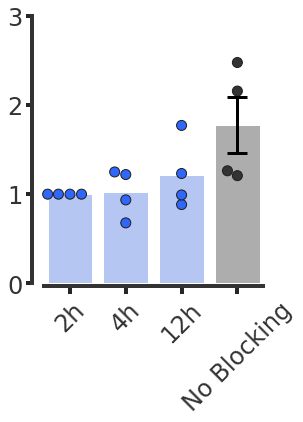

In [32]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")

#y="intensity normd 0 to 1"
var="intensity normd to 2hr"
#y="intensity raw"
#y="raw intensity normd to dio mean"
fig=plt.figure(figsize=(4,5))
order=['2hrs','4hrs','12hrs','No Blocking']
palette ={"No Blocking":"white","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
paletteswarm ={"No Blocking":"#333333","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
edges ={"No Blocking":"gray","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}


palettes ={"No Blocking":"#adadad","2hrs":"#abc2fc","4hrs":"#abc2fc","12hrs":"#abc2fc"}



g=sns.barplot(x="Time",y=var,data=dfmeans,alpha=1,ci=None,palette=palettes,order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        #change edgecolor
        #clr = patch.get_facecolor()
        #if clr==(1.0, 1.0, 1.0, 0.3):
         #   patch.set_edgecolor('#777777')
          #  patch.set_alpha(1)
        #patch.set_edgewidth(3)
        #patch.set_linewidth(10)
        #patch.set_linewidth(4)
        

change_width(g, .8)

g=sns.swarmplot(x="Time",y=var,data=dfmeans,size=10,palette=paletteswarm,linewidth=1,order=order)

plt.errorbar(x=[3],
             y=[dfmeans[dfmeans["Time"]=="No Blocking"][var].mean()
             ],
             yerr=[dfmeans[dfmeans["Time"]=="No Blocking"][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#scale_y=1/100
#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
#g.yaxis.set_major_formatter(ticks_y)

plt.ylim([-0.05,.03])
plt.axhline(-0.08, color='#333333',alpha=1,linewidth=12)

plt.yticks([0,1,2,3],color='#333333')
plt.xticks(g.get_xticks(),['2h','4h','12h','No Blocking'],color='#333333',size=20)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)


#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)


#g.set_ylabel('Normalised \nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),size=24,rotation=45,color='#333333')
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


    
#plt.ylim([0/100,1/100])
#plt.xlim([-1,5])


'''x1, x2 = 0,1
y= 1.6
h=0.01*dfmeans[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')


x1, x2 = 1,2
y= 2.2
h=0.01*dfmeans[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')'''

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

varx = [0.,1.,2.,3.]
vary = [dfmeans[dfmeans["Time"]=="2hrs"][var].mean(),
     dfmeans[dfmeans["Time"]=="4hrs"][var].mean(),
     dfmeans[dfmeans["Time"]=="12hrs"][var].mean(),
     dfmeans[dfmeans["Time"]=="No Blocking"][var].mean()]

from scipy.interpolate import spline

#xnew = np.linspace(min(x), max(x), 10)

#y_smooth = spline(varx, vary, xnew)

#plt.plot(xnew, y_smooth)


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'1a_tnrincreases.svg', bbox_inches='tight', format='svg')



## Find representative pictures for increase after blocking

In [ ]:
df_select=deepcopy(df2)

df_2hrs=df_select[df_select["Time"]=="2hrs"]
df_4hrs=df_select[df_select["Time"]=="4hrs"]
df_12hrs=df_select[df_select["Time"]=="12hrs"]
df_ctrl=df_select[df_select["Time"]=="No Blocking"]

df_2show=df_ctrl


minval=70
maxval=1000
num=1
leng=len(df_2show)
fig=plt.figure(figsize=(30,200))
for i in range(0,len(df_2show)):
    fig.add_subplot(leng,1,num)
    ecm_channel_no=df_2show["ecmchannelno"].values[i]
    with ND2Reader(df_2show["filename"].values[i]) as images:
        #print("Image name:",df_dmso["filename"].values[i].split('/')[-1])
        #print("Experimental condition:",df_dmso["exp condition"].values[i])
        ecm_image_control=images[ecm_channel_no-1]
        plt.imshow(ecm_image_control,interpolation='none',cmap='hot',vmin=minval,vmax=maxval)
        plt.title(df_2show["filename"].values[i].split('/')[-1], size=14)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                               font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
        plt.gca().add_artist(scalebar)
        num+=1
    

## Get the nice pictures


## option 1

In [ ]:
minval=50
maxval=1000

filename_2h="20181002_10_100x_005.nd2"
filename_4h="20181002_05_100x_003.nd2"
filename_12h="20181011_01_100x_001.nd2"
filename_ctrl="20181016_12_100x_002.nd2"

ind_2=df2.loc[df2["filename"].str.contains(filename_2h)]["filename"].values[0]
ind_4=df2.loc[df2["filename"].str.contains(filename_4h)]["filename"].values[0]
ind_12=df2.loc[df2["filename"].str.contains(filename_12h)]["filename"].values[0]
ind_ctrl=df2.loc[df2["filename"].str.contains(filename_ctrl)]["filename"].values[0]

list_names=[ind_2,ind_4,ind_12,ind_ctrl]
num=1
for item in list_names:
    plt.figure(figsize=(5,5))
    ecm_channel_no=1
    with ND2Reader(item) as images:
        #print("Image name:",df_dmso["filename"].values[i].split('/')[-1])
        #print("Experimental condition:",df_dmso["exp condition"].values[i])
        ecm_image_control=images[ecm_channel_no-1]
        if num==3:
            ecm_image_control=ndi.rotate(ecm_image_control,180)
            #ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        if num==4:
            #ecm_image_control=ndi.rotate(ecm_image_control,180)
            #ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        plt.imshow(ecm_image_control,interpolation='none',cmap='gray',vmin=minval,vmax=maxval)
        #plt.title(df2["filename"].values[i].split('/')[-1], size=14)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                               font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
        plt.gca().add_artist(scalebar)
        num+=1

## option 2

In [ ]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

import image
minval=20
maxval=1200

filename_2h="20181016_09_100x_003.nd2"
filename_4h="20181011_07_100x_006.nd2"
filename_12h="20181011_02_100x_004.nd2"
filename_ctrl="20181016_11_100x_007.nd2"

ind_2=df2.loc[df2["filename"].str.contains(filename_2h)]["filename"].values[0]
ind_4=df2.loc[df2["filename"].str.contains(filename_4h)]["filename"].values[0]
ind_12=df2.loc[df2["filename"].str.contains(filename_12h)]["filename"].values[0]
ind_ctrl=df2.loc[df2["filename"].str.contains(filename_ctrl)]["filename"].values[0]

list_names=[ind_2,ind_4,ind_12,ind_ctrl]
num=1

for item in list_names:
    fig=plt.figure(figsize=(5,5))
    ecm_channel_no=1
    with ND2Reader(item) as images:
        #print("Image name:",df_dmso["filename"].values[i].split('/')[-1])
        #print("Experimental condition:",df_dmso["exp condition"].values[i])
        ecm_image_control=images[0]
        if num==2:
            #ecm_image_control=ndi.rotate(ecm_image_control,180)
            #ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        if num==4:
            #ecm_image_control=ndi.rotate(ecm_image_control,180)
            #ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        plt.imshow(ecm_image_control,interpolation='none',cmap='gray',vmin=minval,vmax=maxval)
        #plt.title(item)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        if num==1:
            scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                                   font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
            plt.gca().add_artist(scalebar)
        fig.savefig(diri+str(num)+'_tnr.png', bbox_inches='tight', format='png',
                    pad_inches = 0)
        data = ecm_image_control
        im = Image.fromarray(data)
        im.save(diri+'tnr_increases'+str(num)+'.tiff')
        num+=1

## Plot 12 hr DMSO versus Bic

In [47]:
var="ECM mean intensity after bg subtraction: matlab manual mask only" #change me

means={"expname":[],"intensity normd to 12hr DMSO":[],"Drug":[]}

df2read=df2[df2["Time"]=="12hrs"]

for exp in df2read["expname"].unique():
    dfcalc=df2read[df2read["expname"]==exp]
    
    dfdmso=dfcalc[dfcalc["Drug"]=="DMSO"]
    means["expname"].append(exp)
    dmsomean=dfdmso[var].mean()
    means["intensity normd to 12hr DMSO"].append(1.)
    means["Drug"].append("DMSO")
    
    dfBic=dfcalc[dfcalc["Drug"]=="Bic"]
    means["expname"].append(exp)
    Bicmean=dfBic[var].mean()
    means["intensity normd to 12hr DMSO"].append(Bicmean/dmsomean)
    means["Drug"].append("Bic")
          
dfmeans2=pd.DataFrame(means)

## ttest bic versus dmso at 12 hr

In [48]:
var="intensity normd to 12hr DMSO"
dmso=dfmeans2[dfmeans2["Drug"]=="DMSO"][var].dropna().values
bic=dfmeans2[dfmeans2["Drug"]=="Bic"][var].dropna().values

[stat,pval_2_4]=stats.ttest_ind(dmso, bic)
print(pval_2_4)

0.7406886506094544


## Plot 

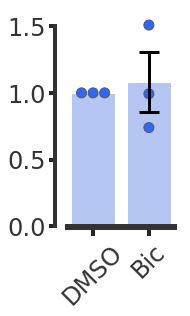

In [50]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")


fig=plt.figure(figsize=(2,4))
order=['DMSO','Bic']
palette ={"No Blocking":"white","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
paletteswarm ={"No Blocking":"#333333","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
edges ={"No Blocking":"gray","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}


palettes ={"No Blocking":"#adadad","2hrs":"#abc2fc","4hrs":"#abc2fc","12hrs":"#abc2fc"}


g=sns.barplot(x="Drug",y=var,data=dfmeans2,alpha=1,ci=None,color="#abc2fc",order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        #change edgecolor
        #clr = patch.get_facecolor()
        #if clr==(1.0, 1.0, 1.0, 0.3):
         #   patch.set_edgecolor('#777777')
          #  patch.set_alpha(1)
        #patch.set_edgewidth(3)
        #patch.set_linewidth(10)
        #patch.set_linewidth(4)
        

change_width(g, .8)

g=sns.swarmplot(x="Drug",y=var,data=dfmeans2,size=10,color="#2F67F8",linewidth=1,order=order)

plt.errorbar(x=[1],
             y=[
             dfmeans2[dfmeans2["Drug"]=="Bic"][var].mean()],
             yerr=[
             dfmeans2[dfmeans2["Drug"]=="Bic"][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([-0.03,1.6])
plt.axhline(-0.02, color='#333333',alpha=1,linewidth=10)

plt.yticks([0,0.5,1,1.5],color='#333333')
plt.xticks(g.get_xticks(),['DMSO','Bic'],color='#333333',size=20)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)


#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),size=24,rotation=45,color='#333333')
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

'''x1, x2 = 0,1
y= 1.5
h=0.01*dfmeans2[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')'''


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'2a_tnrbic.svg', bbox_inches='tight', format='svg')


## Pics

In [ ]:
df_select=deepcopy(df2)

df_pic=df_select[df_select["Time"]=="12hrs"]
df_dmso=df_pic[df_pic["Drug"]=="DMSO"]
df_bic=df_pic[df_pic["Drug"]=="Bic"]


df_2show=df_bic


minval=70
maxval=3000
num=1
leng=len(df_2show)
fig=plt.figure(figsize=(30,200))
for i in range(0,len(df_2show)):
    fig.add_subplot(leng,1,num)
    ecm_channel_no=df_2show["ecmchannelno"].values[i]
    with ND2Reader(df_2show["filename"].values[i]) as images:
        #print("Image name:",df_dmso["filename"].values[i].split('/')[-1])
        #print("Experimental condition:",df_dmso["exp condition"].values[i])
        ecm_image_control=images[ecm_channel_no-1]
        plt.imshow(ecm_image_control,interpolation='none',cmap='hot',vmin=minval,vmax=maxval)
        plt.title(df_2show["filename"].values[i].split('/')[-1], size=14)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                               font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
        plt.gca().add_artist(scalebar)
        num+=1
    

In [ ]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
import image

minval=50
maxval=1500

filename_12h="20181011_03_100x_005.nd2"
filename_12hbic="20181011_01_100x_001.nd2"


ind_2=df2.loc[df2["filename"].str.contains(filename_12h)]["filename"].values[0]
ind_4=df2.loc[df2["filename"].str.contains(filename_12hbic)]["filename"].values[0]


list_names=[ind_2,ind_4]
num=1

for item in list_names:
    fig=plt.figure(figsize=(5,5))
    ecm_channel_no=1
    with ND2Reader(item) as images:
        #print("Image name:",df_dmso["filename"].values[i].split('/')[-1])
        #print("Experimental condition:",df_dmso["exp condition"].values[i])
        ecm_image_control=images[0]
        if num==1:
            #ecm_image_control=ndi.rotate(ecm_image_control,180)
            ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        if num==4:
            #ecm_image_control=ndi.rotate(ecm_image_control,180)
            #ecm_image_control=np.flipud(ecm_image_control)
            ecm_image_control=np.fliplr(ecm_image_control)
        plt.imshow(ecm_image_control,interpolation='none',cmap='inferno',vmin=minval,vmax=maxval)
        #plt.title(item)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        if num==1:
            scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                               font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
            plt.gca().add_artist(scalebar)
        fig.savefig(diri+'tnrbic'+str(num)+'.tiff', bbox_inches='tight', format='tiff',
                    pad_inches = 0)
        fig.savefig(diri+'tnrbic'+str(num)+'.png', bbox_inches='tight', format='png',
                    pad_inches = 0)
        

        data = ecm_image_control
        im = Image.fromarray(data)
        im.save(diri+'tnrbic'+str(num)+'.tiff')
        num+=1

## plot increase in tnr over time

In [5]:
## add time as integer rather than categorical

In [7]:
dfmeans["hours"]=np.nan
dfmeans.loc[dfmeans["Time"]=="2hrs","hours"]=2
dfmeans.loc[dfmeans["Time"]=="4hrs","hours"]=4
dfmeans.loc[dfmeans["Time"]=="12hrs","hours"]=12

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


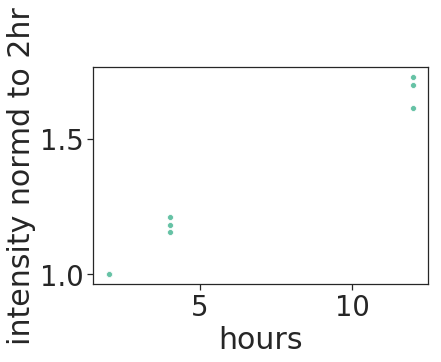

In [10]:
sns.scatterplot(x="hours",y=var,data=dfmeans)

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

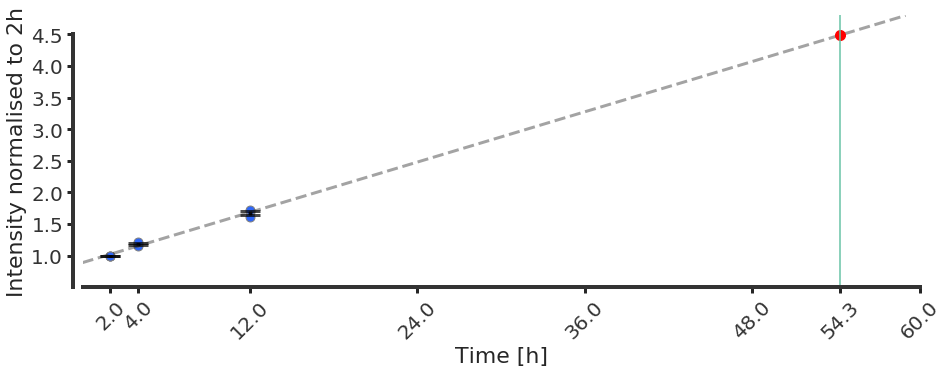

In [73]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")


fig=plt.figure(figsize=(15,5))
order=[2,4,12]
#palette ={"No Blocking":"gray","2hrs":"magenta","4hrs":"magenta","12hrs":"magenta"}


g=sns.scatterplot(x="hours",y=var,
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')


plt.errorbar(x = order,
             y=[dfmeans[dfmeans["hours"]==x][var].mean() for x in order],
             yerr=[dfmeans[dfmeans["hours"]==x][var].sem() for x in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = order,
             y=[dfmeans[dfmeans["hours"]==x][var].mean() for x in order],
             yerr=None,
             xerr=np.repeat(.14,len(order)),ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)



#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

g.grid(False)
plt.ylim([0.5,4.8])
plt.xlim([0,60])


x=dfmeans[dfmeans["Time"]!="No Blocking"]["hours"]
y=dfmeans[dfmeans["Time"]!="No Blocking"][var]
m,b = np.polyfit(x, y, 1) 

xlong=np.arange(0,60)
plt.plot( xlong, m*xlong+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

#calculate where non blocked falls on line
mean_unblocked=dfmeans[dfmeans["Time"]=="No Blocking"]["intensity normd to 2hr"].mean()
x_on_linreg=(mean_unblocked-b)/m
plt.plot(x_on_linreg,mean_unblocked,'o',markersize=10,color='red')
plt.axvline(x=x_on_linreg)

g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":True,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)


#g.set_ylabel('TNR Normalised\nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
#g.set_xlabel('Syt1 Normalised\nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('Intensity normalised to 2h',size=22)
g.set_xlabel('Time [h]',size=22)
plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5],color='#333333',size=20)
plt.xticks([2,4,12,24,36,48,54.3,60],color='#333333',size=20,rotation=45)


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
#fig.savefig(diri+'2b_tnrsytcorr_option2.svg', bbox_inches='tight', format='svg')

In [75]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(x,y)
print("R squared: " + str(pearson**2))
print("pval: "+str(pval))

R squared: 0.9835040838310569
pval: 1.6887100589848805e-07
